# Geo Image Classification

Note: A system with GPU is preferred for DL model training

## Dataset
- https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-25 14:07:06.341061: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 14:07:06.357765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735135626.376606     508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735135626.382596     508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 14:07:06.402731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.__version__

'2.18.0'

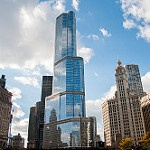

In [8]:
path = '../data/seg_train/seg_train/buildings'
name = '10198.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [9]:
img = load_img(fullname, target_size=(299, 299))

In [10]:
x = np.array(img)
x.shape

(299, 299, 3)

In [11]:
x

array([[[159, 172, 189],
        [159, 172, 189],
        [159, 172, 189],
        ...,
        [232, 231, 229],
        [231, 230, 228],
        [231, 230, 228]],

       [[159, 172, 189],
        [159, 172, 189],
        [159, 172, 189],
        ...,
        [232, 231, 229],
        [231, 230, 228],
        [231, 230, 228]],

       [[159, 172, 189],
        [159, 172, 189],
        [159, 172, 189],
        ...,
        [230, 229, 227],
        [228, 227, 225],
        [228, 227, 225]],

       ...,

       [[104,  89,  82],
        [104,  89,  82],
        [ 44,  33,  27],
        ...,
        [ 58,  44,  35],
        [ 52,  38,  27],
        [ 52,  38,  27]],

       [[ 35,  20,  13],
        [ 35,  20,  13],
        [ 49,  38,  32],
        ...,
        [ 41,  27,  18],
        [ 58,  44,  35],
        [ 58,  44,  35]],

       [[ 35,  20,  13],
        [ 35,  20,  13],
        [ 49,  38,  32],
        ...,
        [ 41,  27,  18],
        [ 58,  44,  35],
        [ 58,  44,  35]]

## Pre-trained convolutional neural networks
- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/

In [12]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1735136043.129399     508 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [13]:
X = np.array([x])

In [14]:
X.shape

(1, 299, 299, 3)

In [15]:
X = preprocess_input(X)

In [16]:
pred = model.predict(X)

I0000 00:00:1735136052.364754    2404 service.cc:148] XLA service 0x7fc8e40044b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735136052.364797    2404 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-25 14:14:12.401758: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735136052.723449    2404 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-25 14:14:13.864465: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1735136054.688528    2404 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [17]:
decode_predictions(pred)

[[('n03837869', 'obelisk', np.float32(0.08752891)),
  ('n02894605', 'breakwater', np.float32(0.054656498)),
  ('n02930766', 'cab', np.float32(0.03961592)),
  ('n02825657', 'bell_cote', np.float32(0.03613692)),
  ('n02692877', 'airship', np.float32(0.03377251))]]

 - Using a pre-trained model (trained on Imagenet dataset) directly for predictions do not provide expected results 

## Transfer learning
- Reading data with `ImageDataGenerator`
- Train `Xception` on smaller images (150x150)

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    '../data/seg_train/seg_train',
    target_size=(150, 150),
    batch_size=32
)

Found 14046 images belonging to 6 classes.


In [19]:
train_ds.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [20]:
X, y = next(train_ds)

In [21]:
y[:5]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [23]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    '../data/seg_test/seg_test',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3006 images belonging to 6 classes.


In [28]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False



inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

In [29]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.8443 - loss: 0.5580 - val_accuracy: 0.8330 - val_loss: 0.7556
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8845 - loss: 0.4449 - val_accuracy: 0.8450 - val_loss: 0.7103
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9003 - loss: 0.3983 - val_accuracy: 0.8689 - val_loss: 0.5938
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9122 - loss: 0.3307 - val_accuracy: 0.8812 - val_loss: 0.5679
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9195 - loss: 0.3057 - val_accuracy: 0.8679 - val_loss: 0.6563
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9258 - loss: 0.2765 - val_accuracy: 0.8889 - val_loss: 0.6178
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9293 - loss: 0.2653 - val_accuracy: 0.8772 - val_loss: 0.7210
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9286 - loss: 0.2710 - 

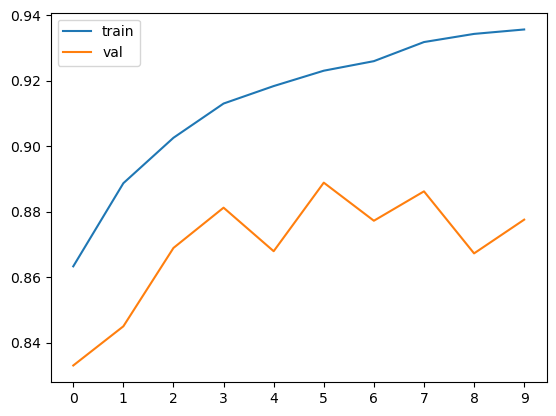

In [34]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Adjusting the learning rate
- What's the learning rate
- Trying different values

In [35]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [36]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6229 - loss: 1.0979 - val_accuracy: 0.8669 - val_loss: 0.4503
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8764 - loss: 0.4095 - val_accuracy: 0.8912 - val_loss: 0.3502
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8961 - loss: 0.3256 - val_accuracy: 0.8896 - val_loss: 0.3168
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8997 - loss: 0.2964 - val_accuracy: 0.8952 - val_loss: 0.2989
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9055 - loss: 0.2801 - val_accuracy: 0.8955 - val_loss: 0.2890
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9047 - loss: 0.2701 - val_accuracy: 0.9012 - val_loss: 0.2838
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9072 - loss: 0.2664 - val_accuracy: 0.9039 - val_loss: 0.2737
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9125 - loss: 0.

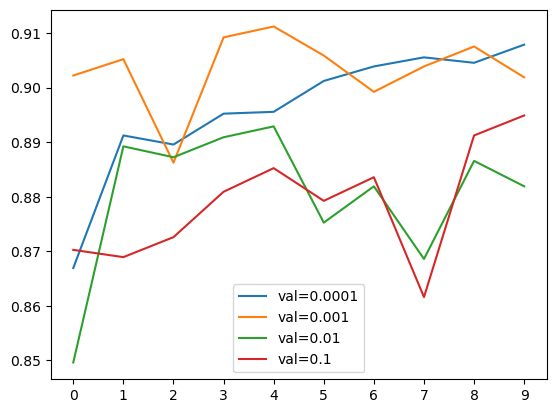

In [38]:
for lr, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [39]:
del scores[0.1]
del scores[0.01]

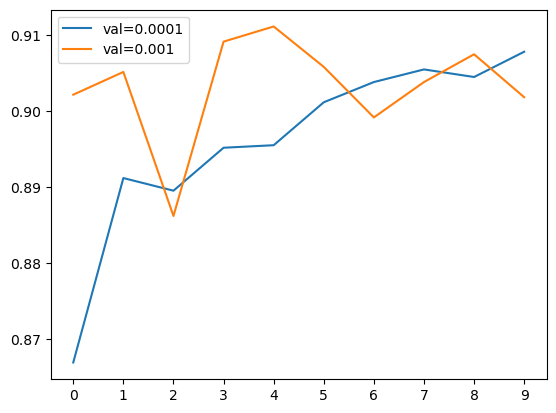

In [40]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
learning_rate = 0.0001

## Checkpointing
- Saving the best model only
- Training a model with callbacks

In [41]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [42]:
learning_rate = 0.0001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.5770 - loss: 1.1935 - val_accuracy: 0.8676 - val_loss: 0.4557
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8742 - loss: 0.4216 - val_accuracy: 0.8832 - val_loss: 0.3503
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.8895 - loss: 0.3375 - val_accuracy: 0.8939 - val_loss: 0.3149
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8994 - loss: 0.3028 - val_accuracy: 0.8929 - val_loss: 0.2977
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9020 - loss: 0.2937 - val_accuracy: 0.8992 - val_loss: 0.2863
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9146 - loss: 0.2593 - val_accuracy: 0.9012 - val_loss: 0.2783
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9039 - loss: 0.2700 - val_accuracy: 0.9015 - val_loss: 0.2741
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9117 - loss: 0.2568 - 

## Adding more layers
- Adding one inner dense layer
- Experimenting with different sizes of inner layer

In [43]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [44]:
learning_rate = 0.0001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.5166 - loss: 1.2509 - val_accuracy: 0.8417 - val_loss: 0.5142
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8659 - loss: 0.4475 - val_accuracy: 0.8819 - val_loss: 0.3540
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8904 - loss: 0.3352 - val_accuracy: 0.8925 - val_loss: 0.3094
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9037 - loss: 0.2868 - val_accuracy: 0.8985 - val_loss: 0.2914
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9046 - loss: 0.2755 - val_accuracy: 0.9022 - val_loss: 0.2814
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9059 - loss: 0.2703 - val_accuracy: 0.9002 - val_loss: 0.2749
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9102 - loss: 0.2486 - val_accuracy: 0.9025 - val_loss: 0.2689
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9175 - loss: 0.2334

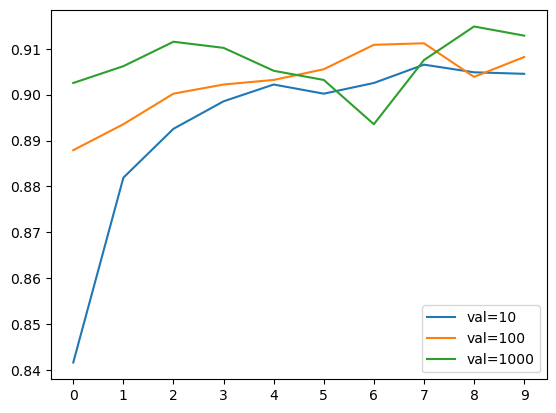

In [47]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
# plt.yticks([0.83, 0.85, 0.87, 0.89, 0.91, 0.93])
plt.legend()

- Let's go with size_inner=100

## Regularization and dropout
- Regularizing by freezing a part of the network
- Adding dropout to our model
- Experimenting with different values

In [48]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [49]:
learning_rate = 0.0001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.7808 - loss: 0.6989 - val_accuracy: 0.8932 - val_loss: 0.2935
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9078 - loss: 0.2643 - val_accuracy: 0.9029 - val_loss: 0.2720
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9164 - loss: 0.2352 - val_accuracy: 0.9062 - val_loss: 0.2611
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9206 - loss: 0.2191 - val_accuracy: 0.9062 - val_loss: 0.2559
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9260 - loss: 0.2046 - val_accuracy: 0.8985 - val_loss: 0.2638
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9350 - loss: 0.1894 - val_accuracy: 0.9002 - val_loss: 0.2664
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9369 - loss: 0.1798 - val_accuracy: 0.9045 - val_loss: 0.2510
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9439 - loss: 0.168

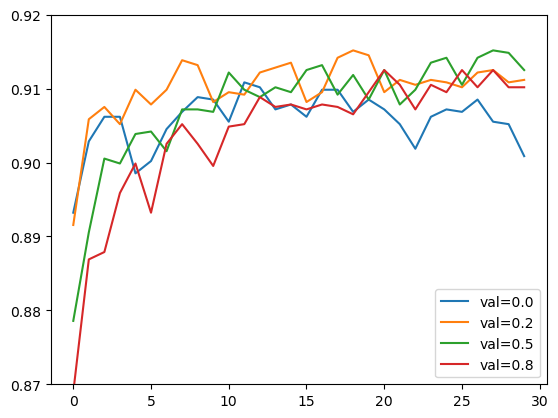

In [52]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.87, 0.92)
plt.legend()

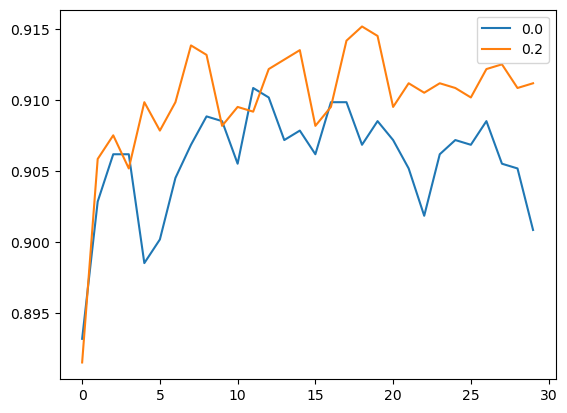

In [56]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
# plt.plot(hist['accuracy'], label=('val=%s' % droprate))

## Data augmentation
- Different data augmentations
- Training a model with augmentations
- How to select data augmentations?

In [57]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    '../data/seg_train/seg_train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    '../data/seg_test/seg_test',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 14046 images belonging to 6 classes.
Found 3006 images belonging to 6 classes.


In [58]:
learning_rate = 0.0001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.7000 - loss: 0.8318 - val_accuracy: 0.8925 - val_loss: 0.3089
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.8872 - loss: 0.3068 - val_accuracy: 0.8932 - val_loss: 0.2800
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9074 - loss: 0.2627 - val_accuracy: 0.9019 - val_loss: 0.2640
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9086 - loss: 0.2524 - val_accuracy: 0.9072 - val_loss: 0.2566
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9155 - loss: 0.2320 - val_accuracy: 0.9035 - val_loss: 0.2607
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9195 - loss: 0.2249 - val_accuracy: 0.9112 - val_loss: 0.2520
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9284 - loss: 0.2047 - val_accuracy: 0.9079 - val_loss: 0.2471
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9299 - loss: 0.1958 - 

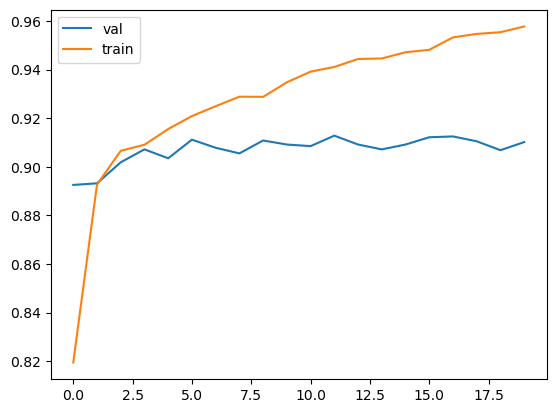

In [59]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Training a larger model
- Train a 299x299 model

In [60]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [61]:
input_size = 299

In [62]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    '../data/seg_train/seg_train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    '../data/seg_test/seg_test',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 14046 images belonging to 6 classes.
Found 3006 images belonging to 6 classes.


In [63]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [64]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=20, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/20


2024-12-25 16:39:18.389814: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


185/439 ━━━━━━━━━━━━━━━━━━━━ 2:15 532ms/step - accuracy: 0.7603 - loss: 0.7185

2024-12-25 16:41:07.303210: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8200 - loss: 0.5262

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 313s 680ms/step - accuracy: 0.8201 - loss: 0.5258 - val_accuracy: 0.9108 - val_loss: 0.2424
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 284s 647ms/step - accuracy: 0.9093 - loss: 0.2438 - val_accuracy: 0.9145 - val_loss: 0.2174
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 284s 648ms/step - accuracy: 0.9150 - loss: 0.2246 - val_accuracy: 0.9138 - val_loss: 0.2228
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 306s 697ms/step - accuracy: 0.9266 - loss: 0.2018 - val_accuracy: 0.9232 - val_loss: 0.2060
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 300s 684ms/step - accuracy: 0.9235 - loss: 0.1954 - val_accuracy: 0.9208 - val_loss: 0.2031
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 282s 641ms/step - accuracy: 0.9291 - loss: 0.1880 - val_accuracy: 0.9192 - val_loss: 0.2130
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 284s 647ms/step - accuracy: 0.9364 - loss: 0.1741 - val_accuracy: 0.9172 - val_loss: 0.2126
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 285s 649ms/step - accuracy: 0.9366 - loss: 0.17